# Chapter 7. Image Segmentation with UNet

# 7.1. Import Libraries

In [1]:
# For metadata/feature processing
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import os
import shutil

# For neural network
import tensorflow as tf

# For image
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Configs

In [2]:
NUM_FOLDS = 1
EPOCHS = 30
BATCH_SIZE = 100
IMG_SIZE = [128, 128]

# 7.2. Meta Data
Not all dataset comes with prepared **metadata** (csv file containing file/image/feature/label info). Thus we need to learn how to prepare one for a custom dataset.

## Get Image Paths
First we'll use `glob` to access the file paths of each image to link them to their labels and data split.



In [3]:
paths = glob('/kaggle/input/new-idd-dataset/IDD_RESIZED/image_archive/*')
print(f"Num Train: {len(paths)}")

Num Train: 6993


## Build DataFrame (CSV File)

In [4]:
print('Train:')
df = pd.DataFrame(paths, columns=['image_path'])
display(df.head(2))

Train:


image_path
0  /kaggle/input/new-idd-dataset/IDD_RESIZED/imag...
1  /kaggle/input/new-idd-dataset/IDD_RESIZED/imag...

# 7.3. Retreive Metadata
In the following cell we'll retreive `train-test` split and `class` infomation from **image path**. 


In [5]:
df['filename'] = df.image_path.map(lambda x: x.split('/')[-1])
df['folder'] = df.image_path.map(lambda x: x.split('/')[-2])
df['mask_path'] = df.image_path.map(lambda x: x.replace('image','mask').replace("Image","Mask"))
df['has_mask'] = df.mask_path.map(lambda x: os.path.isfile(x))
display(df.head(2))


image_path        filename  \
0  /kaggle/input/new-idd-dataset/IDD_RESIZED/imag...  Image_4213.png   
1  /kaggle/input/new-idd-dataset/IDD_RESIZED/imag...   Image_281.png   

          folder                                          mask_path  has_mask  
0  image_archive  /kaggle/input/new-idd-dataset/IDD_RESIZED/mask...      True  
1  image_archive  /kaggle/input/new-idd-dataset/IDD_RESIZED/mask...      True

In [6]:
df.has_mask.value_counts()

True    6993
Name: has_mask, dtype: int64

# 7.4. Data Split

In [7]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {len(train_df)}")
print(f"Valid: {len(valid_df)}")

Train: 5594
Valid: 1399


# 7.5. Data Check

Before diving deeper into the analysis, it's crucial to ensure that our metadata – including path and label – aligns accurately with the actual data. Any discrepancies may lead to inaccurate results, undermining the integrity of our findings.


## Utility

In [8]:
# opencv (cv2) is used for loading image
def load_image(path, mask=False):
    img = cv2.imread(path, -1) # `-1` means load image as it is, thus no gray to rgb conversion
    if not mask:
        img = img[...,::-1] # bgr to rgb
    else:
        if len(img.shape)>2:
            img = img[...,0:1]
    return img

## One Sample

In [9]:
def show_sample(img, msk):
    
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.imshow(img);
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(msk);
    plt.title("Mask")


    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(np.ma.masked_where(msk==0, msk), alpha=0.30, cmap='coolwarm_r')
    plt.title("Overlay")

    plt.tight_layout()
    plt.show()
    

## Image Shape: (512, 512, 3)


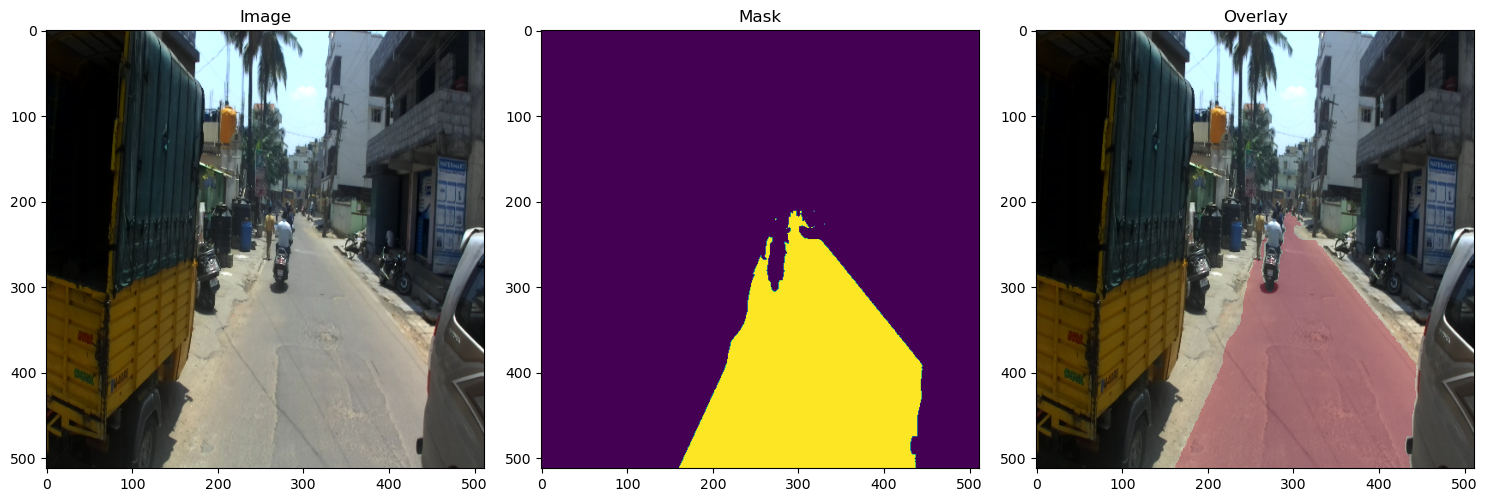

In [10]:
row = df.iloc[100]

img = load_image(row.image_path)

print(f"## Image Shape: {img.shape}")

msk = load_image(row.mask_path, 1)

show_sample(img, msk)

## Multiple Samples

## Image Shape: (512, 512, 3)


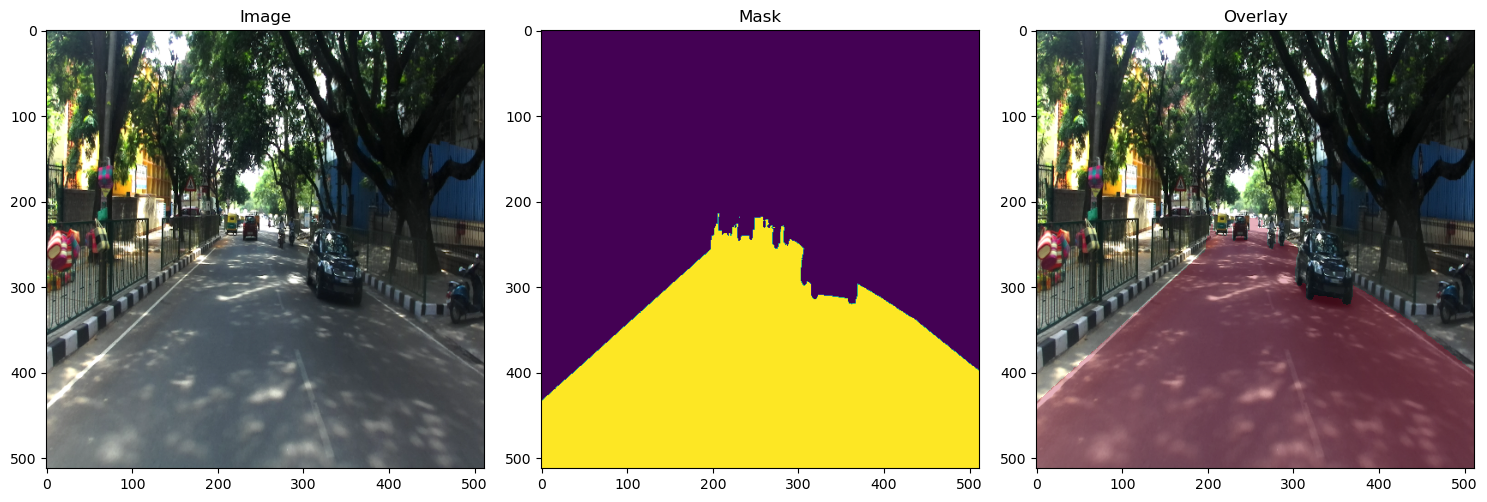

## Image Shape: (512, 512, 3)


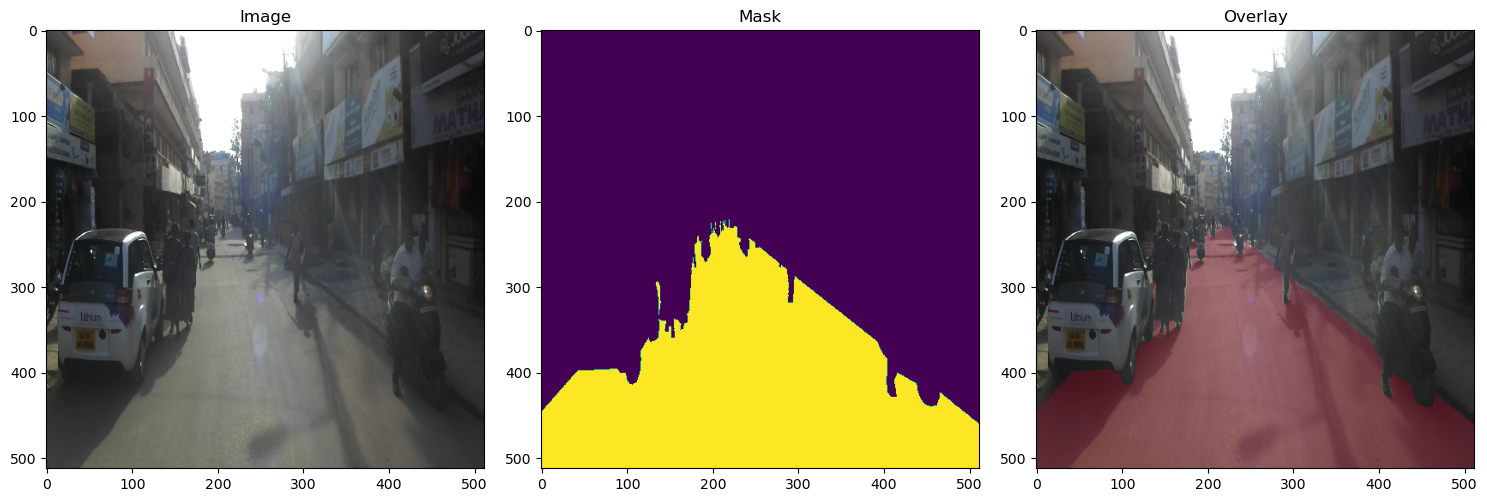

## Image Shape: (512, 512, 3)


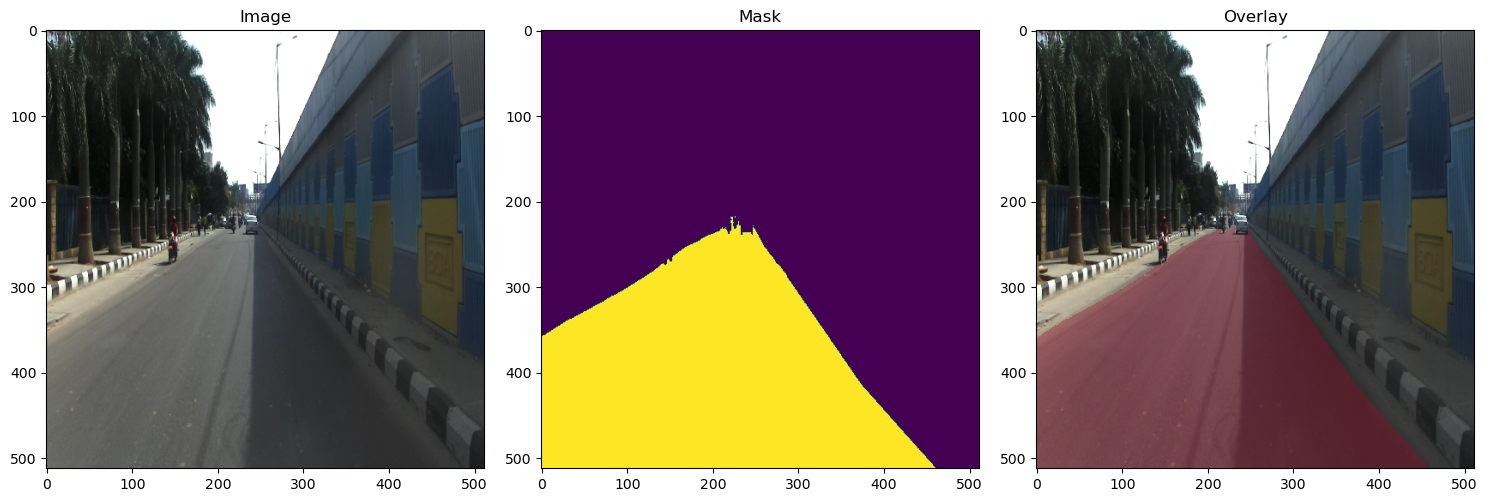

## Image Shape: (512, 512, 3)


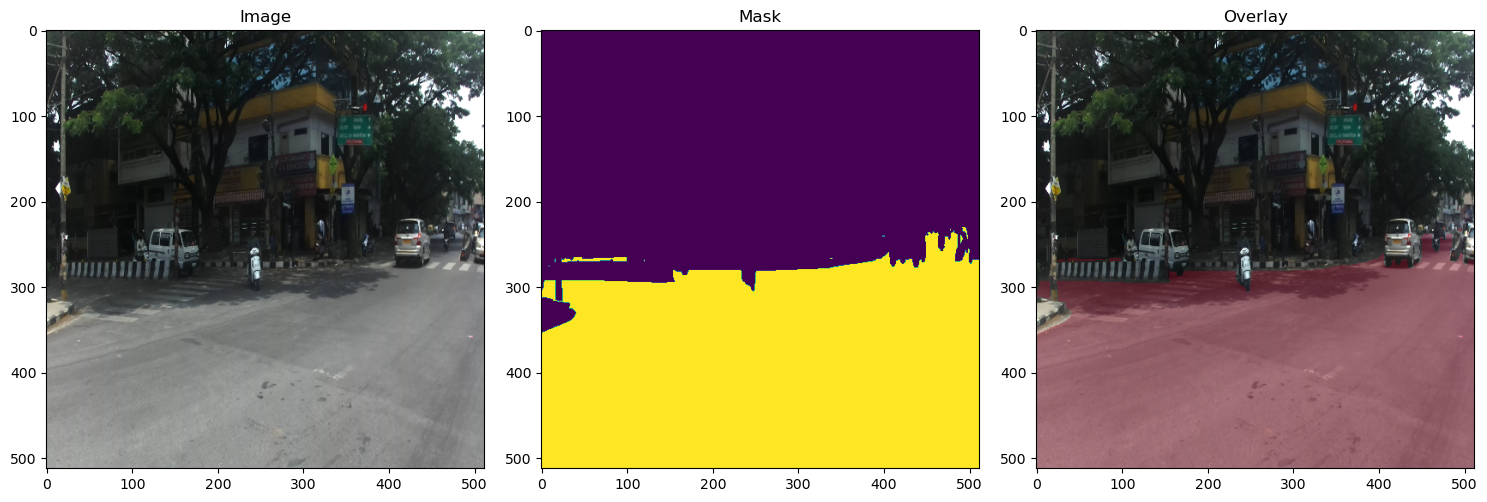

In [11]:
# Set the indices of the samples you want to display
sample_indices = range(0, 100, 25)

for i in sample_indices:
    row = df.iloc[i]

    img = load_image(row.image_path)
    print(f"## Image Shape: {img.shape}")

    msk = load_image(row.mask_path, 1)

    show_sample(img, msk)

# 7.6. Data Loader
Processing large datasets that consume a significant amount of memory can be challenging. Thus loading full data on memory is not feasible. By generating and batching datasets using multiple cores in real-time, it becomes possible to seamlessly integrate them with deep learning models.

In [12]:
import albumentations as A

class DataLoader(tf.keras.utils.Sequence):
    """
    Custom data loader for Keras model training.
    Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

    Args:
        paths (list): List of file paths for the images.
        labels (list): List of corresponding labels for the images. 
                       Set labels= None if you are infering on test dataset (where you dont have labels)
        batch_size (int): Number of samples per batch.
        num_classes (int): Number of classes in the dataset.
        dim (tuple): Dimensions of the input images.
        shuffle (bool): Whether to shuffle the data after each epoch.

    Methods:
        __len__(): Returns the number of batches per epoch.
        __getitem__(index): Generates one batch of data.
        on_epoch_end(): Updates indexes after each epoch.
        __data_generation(batch_indexes): Generates data for a batch.
    """

    def __init__(self, img_paths, msk_paths=None, batch_size=32, num_classes=1,
                 dim=(128, 128), shuffle=True, augment=False, augment_fn=None):
        """Initialization method for the DataLoader class."""
        self.img_paths = img_paths
        self.msk_paths = msk_paths
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.dim = dim
        self.shuffle = shuffle
        
        # For augmentation
        self.augment = augment
        self.augment_fn = augment_fn
        if self.augment and self.augment_fn is None:
            self.augment_fn = A.Compose([A.HorizontalFlip(p=0.5),
                                         A.RandomBrightnessContrast(p=0.5),
                                         A.Rotate(limit=30, p=0.5)])
                                        
        self.on_epoch_end()

    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        """Generates one batch of data."""
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data
        batch = self.__data_generation(batch_indexes)

        return batch

    def on_epoch_end(self):
        """Updates indexes after each epoch."""
        self.indexes = np.arange(len(self.img_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_indexes):
        """Generates data containing batch_size samples."""
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        if self.msk_paths is not None:
            y = np.empty((self.batch_size, *self.dim, self.num_classes), dtype=np.float32)

        # Generate data
        for i, idx in enumerate(batch_indexes):
            # Load image
            img = load_image(self.img_paths[idx])
            img = cv2.resize(img, dsize=self.dim, interpolation=cv2.INTER_AREA)
            img = img[...,:3]
            
            # Load mask
            if self.msk_paths is not None:
                msk = load_image(self.msk_paths[idx], mask=True)
                msk = cv2.resize(msk, dsize=self.dim, interpolation=cv2.INTER_NEAREST)
                msk = msk[...,None]
            
            # Apply augmentation
            if self.augment:
                if self.msk_paths is not None:
                    data = self.augment_fn(image=img, mask=msk)
                    img = data["image"]
                    msk = data["mask"]
                else:
                    data = self.augment_fn(image=img)
                    img = data["image"]
                
            # Store sample
            X[i,] = img

            # Store class
            if self.msk_paths is not None:
                y[i] = msk

        # Flatten the image pixels for Dense layer
#         X = X.reshape(self.batch_size, -1)  # shape: (32, 28, 28) => (32, 28*28) => (32, 784)

        # Do scaling, range: [0, 255] => [0, 1]
        X = X / 255.0
        X = X.clip(0, 1)

        # Apply one-hot encoding to msk_paths [0, 1, 2] => [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
        if self.msk_paths is not None:
#             y = y / 255.0
#             y[y>0.0] = 1.0 # issue with dataset (uniques: 0, 64, 255)
            y = y.clip(0, 1)
#             y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes) # for more than one class
            return X, y
        
        # if there is labels = None, then only return X
        return X

## Loader check

In [13]:
img_paths = df.image_path.tolist()
msk_paths = df.mask_path.tolist()

train_loader = DataLoader(img_paths, msk_paths, batch_size=16, augment=0)

imgs, msks = train_loader.__getitem__(0)
print("Images:\n", imgs.shape)

print("\nLabels:\n", msks.shape)

Images:
 (16, 128, 128, 3)

Labels:
 (16, 128, 128, 1)


## Visualize Loader

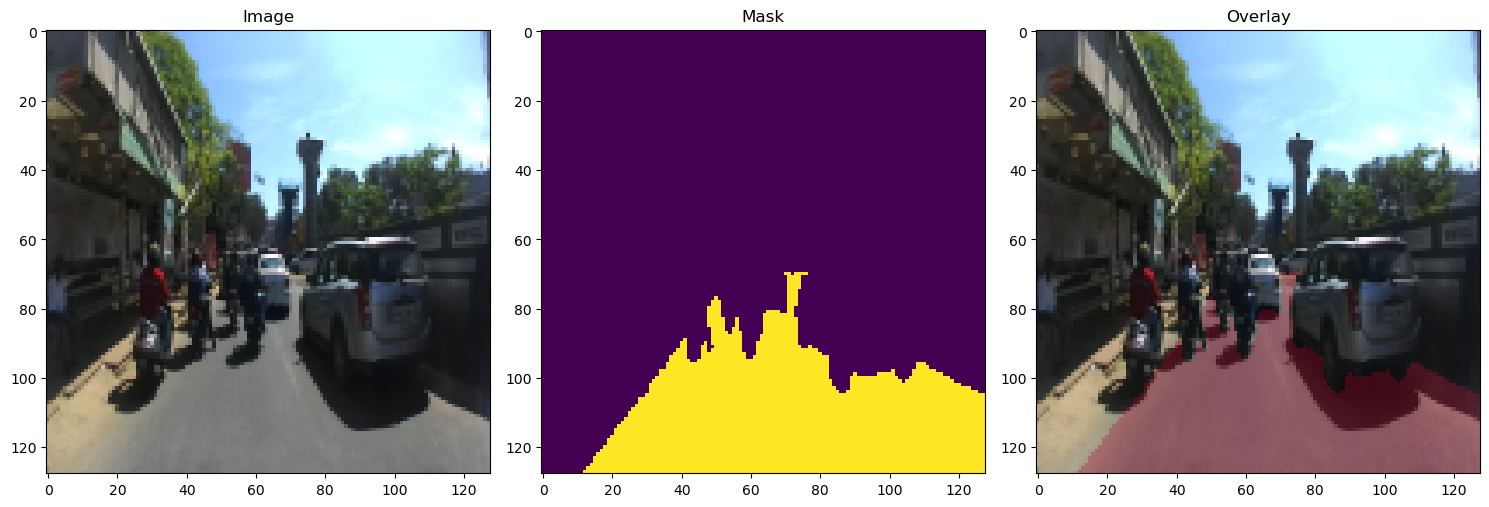

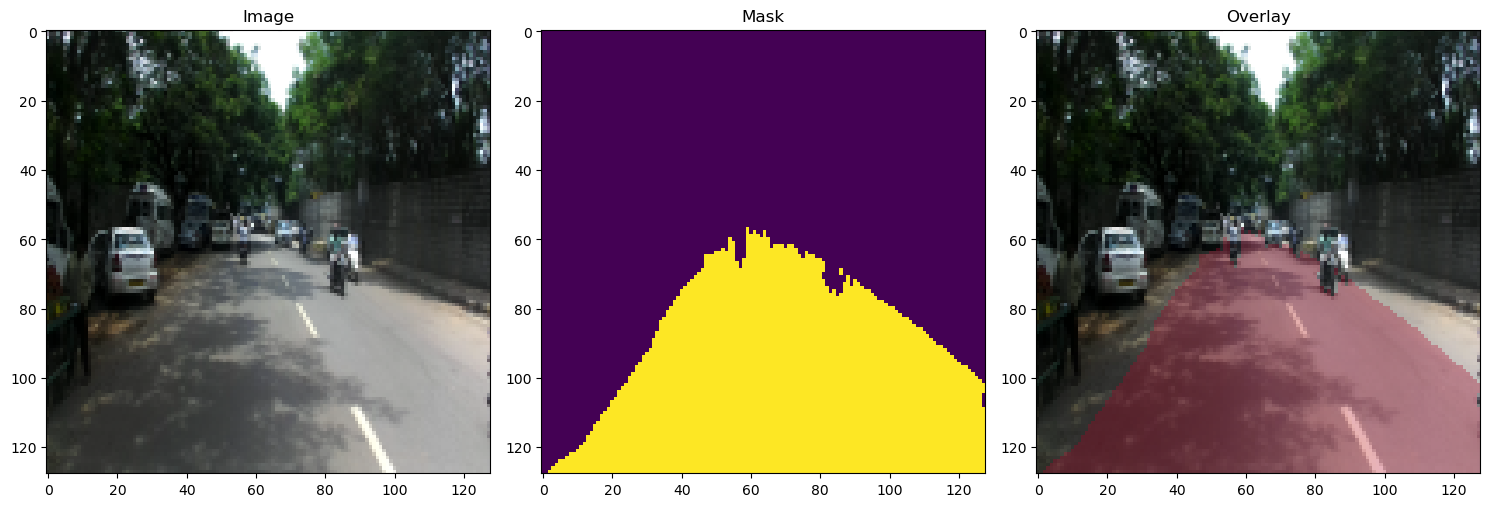

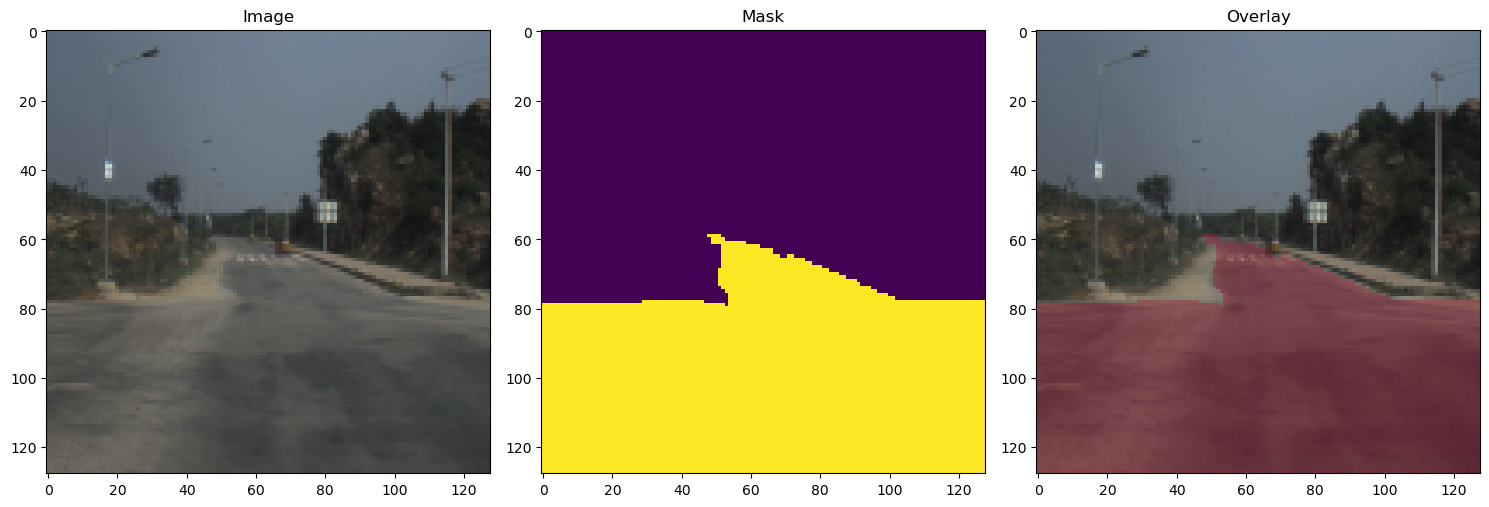

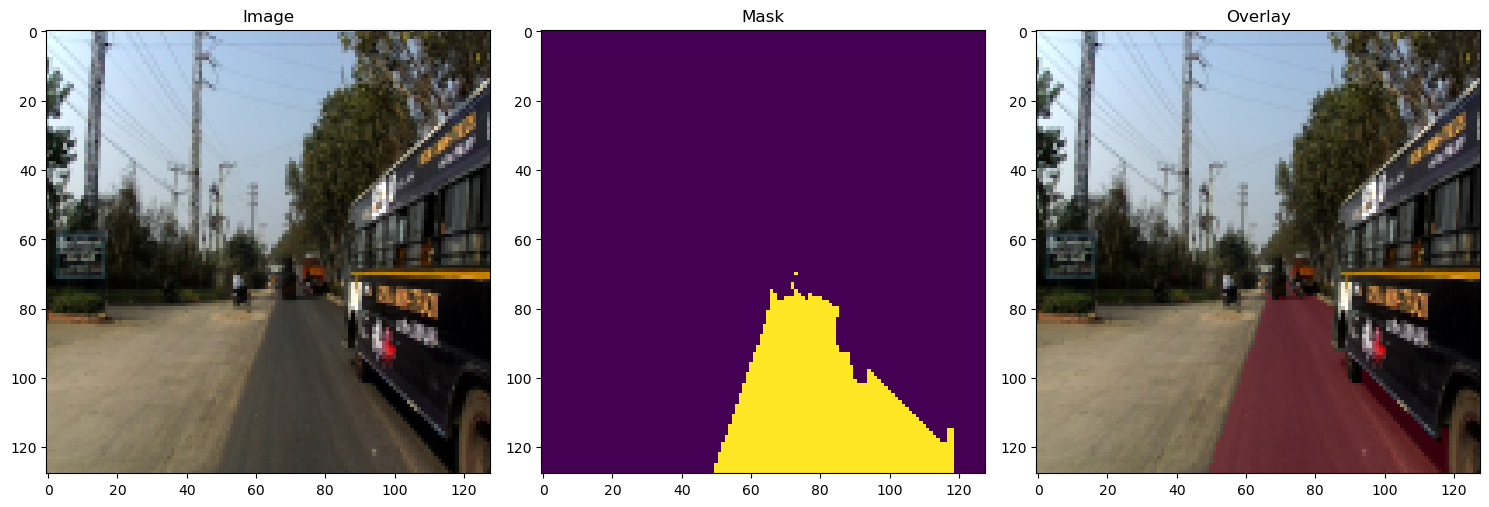

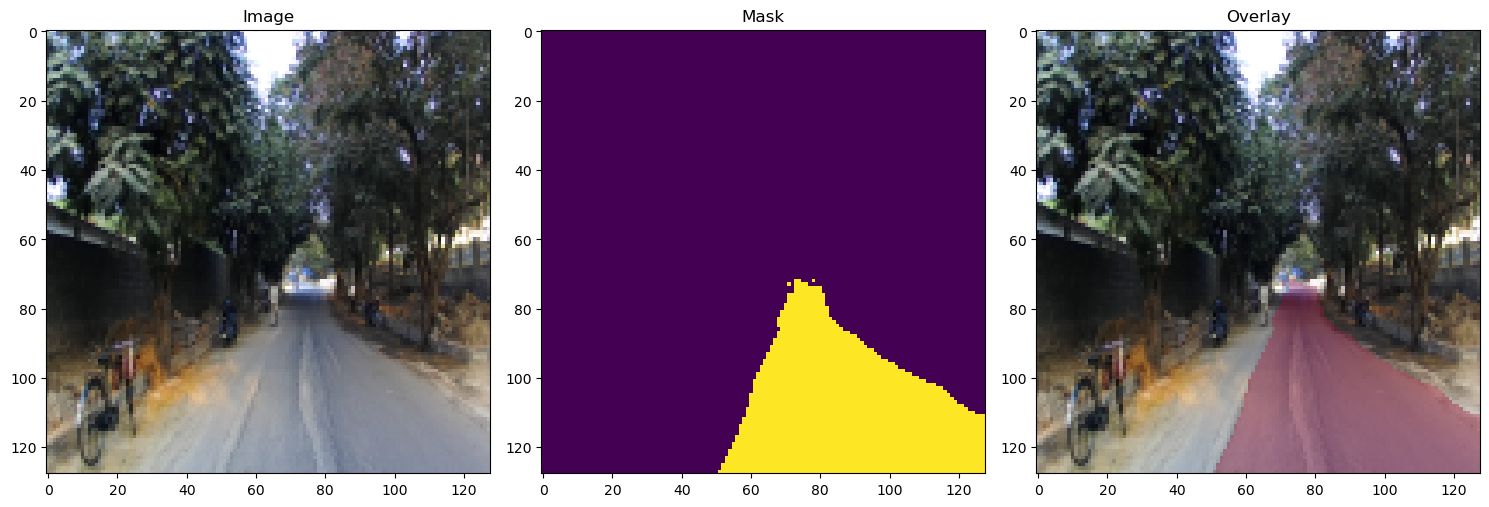

In [14]:
# Set the indices of the samples you want to display
sample_indices = range(0, 10, 2)

for i in sample_indices:
    row = df.iloc[i]

    img = imgs[i]

    msk = msks[i]

    show_sample(img, msk)

## Utils

In [15]:
import matplotlib.pyplot as plt

def plot_history(history, fold=0):
    # summarize history for dice
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['dice'], '-o')
    plt.plot(history.history['val_dice'], '-o')
    plt.title('Dice vs Epoch')
    plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation dice is max
    best_val_acc = max(history.history['val_dice'])
    best_val_acc_epoch = history.history['val_dice'].index(best_val_acc)
    plt.annotate(f'best: {best_val_acc:.2f} @ {best_val_acc_epoch+1}',
                 xy=(best_val_acc_epoch, best_val_acc),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    # summarize history for loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], '-o')
    plt.plot(history.history['val_loss'], '-o')
    plt.title(f'Fold-{fold}: Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

    # Get the epoch at which the validation loss is min
    best_val_loss_epoch = best_val_acc_epoch
    best_val_loss = history.history['val_loss'][best_val_loss_epoch]
    plt.annotate(f'best: {best_val_loss:.2f} @ {best_val_loss_epoch+1}',
                 xy=(best_val_loss_epoch, best_val_loss),
                 xytext=(-20, 20),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='orange', shrink=0.05),
                 fontsize=10,
                 color='black')

    plt.tight_layout()
    plt.show()

# 7.7. Metrics

## Dice Score

The Dice Score, also known as the Dice Coefficient, Sørensen–Dice coefficient, or Dice Similarity Coefficient (DSC), is a statistical tool used for comparing the similarity of two samples. It was developed by Lee Raymond Dice, an American botanist, hence the name "Dice Score."

The Dice Score is particularly useful for comparing the pixel-wise agreement between a predicted segmentation and its corresponding ground truth (i.e., the "gold standard" provided by human annotators).

The Dice Score is defined as:

$$
Dice = \frac{2 \cdot |X \cap Y|}{|X| + |Y|}
$$

where $X$ is the predicted segmentation and $Y$ is the ground truth. $|X \cap Y|$ refers to the common elements between the predicted and the ground truth, and $|X|$ and $|Y|$ are the total number of elements in $X$ and $Y$ respectively.


<img src="https://miro.medium.com/v2/resize:fit:1400/1*tSqwQ9tvLmeO9raDqg3i-w.png">

![Metrics diagram](https://newbiettn.github.io/images/precision-recall.jpg)

<img src="https://miro.medium.com/v2/resize:fit:1400/1*Z1hkDvyhFBogT9EkzVkX2A.png" width="600">


> The Dice Score has a range of [0, 1] where a Dice Score of 1 signifies the perfect overlap i.e., perfect prediction, and a Dice Score of 0 signifies no overlap i.e., complete misclassification.



## Dice Score vs. Cross Entropy

In many cases, especially in medical image segmentation, the Dice Score is used as the loss function instead of Cross Entropy. The main reasons for this are:

1. **Imbalanced classes**: Medical images often have imbalanced classes. For example, if we are trying to identify a small tumor in a large image, the pixels of the tumor class are vastly outnumbered by the pixels of the non-tumor class. In such a case, a model trained with Cross Entropy could be biased towards the majority class, leading to a poor performance on the minority class (tumor). The Dice Score, on the other hand, takes into account both false positives and false negatives, and is therefore more suitable for imbalanced data. In the code, `dice` is calculated **classwise** so each class score is weighted equally.

2. **Spatial Information**: The Dice Score captures spatial information. By considering the overlap between the predicted and actual regions, it rewards the correct prediction of contiguous regions, which is important in image segmentation.



In [16]:
def dice(y_true, y_pred, axis=(0, 1, 2), smooth=0.0001, thr=0.5):
    y_true = tf.cast(y_true, tf.float32) # (B, H, W, C)
    y_pred = tf.cast(y_pred > thr, tf.float32) # (B, H, W, C)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    dice = (2*tp + smooth) / (2*tp + fn + fp + smooth) # calculate Dice score
    dice = tf.math.reduce_mean(dice) # average over all classes
    return dice # Dice loss is 1 - Dice score

# 7.8. Loss Function

In [17]:
def dice_loss(y_true, y_pred, axis=(0, 1, 2), smooth=0.0001):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    dice = (2*tp + smooth) / (2*tp + fn + fp + smooth) # calculate Dice score
    dice = tf.math.reduce_mean(dice) # average over all classes
    return 1. - dice # Dice loss is 1 - Dice score

## IoU (Intersection Over Union)
<img src="https://www.researchgate.net/publication/353925131/figure/fig3/AS:1057411032969216@1629117844237/The-Intersection-over-Unit-IoU-The-formula-of-IoU-The-IoU-is-the-value-between-0-and.png" width="500">

<img src="https://miro.medium.com/v2/resize:fit:1400/1*Pz_A6zOpFXWZg85bfPUjXA.png" width="600">

<img src="https://miro.medium.com/v2/resize:fit:720/1*tzVOaJmX7xxJt_9QpnWEdQ.png">

# 7.9. UNet

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network architecture is named U-Net because of its U-shaped symmetric structure.

**Major Contributions of U-Net:**

1. **Efficient Architecture:** U-Net's architecture, inspired by the fully convolutional network, only contains convolutional layers and does not have any fully connected layers, making it more memory-efficient for high-resolution images.
2. **Encoder-Decoder Structure:** U-Net introduced an architecture that consists of a contracting path (encoder) to capture the context and a symmetric expanding path (decoder) that allows precise localization, forming a 'U' shape.
3. **Skip Connections:** U-Net's architecture includes skip connections that pass information from each level of the contracting path over to the corresponding level in the expanding path. This helps in capturing fine-grained details that are lost during downsampling.

**Architecture**

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="700">

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def UNet(input_shape, first_filters=64, num_classes=1):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Contracting path (encoder)
    
    # Layer 1
    conv1 = Conv2D(first_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(first_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    # Layer 2
    conv2 = Conv2D(first_filters*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(first_filters*2, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    # Layer 3
    conv3 = Conv2D(first_filters*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(first_filters*4, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    # Layer 4
    conv4 = Conv2D(first_filters*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(first_filters*8, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    
    # Middle layer
    convm = Conv2D(first_filters*16, (3, 3), activation='relu', padding='same')(pool4)
    convm = Conv2D(first_filters*16, (3, 3), activation='relu', padding='same')(convm)
    
    # Expanding path (decoder)
    
    # Layer 4
    up4 = concatenate([UpSampling2D((2, 2))(convm), conv4], axis=3)
    conv4 = Conv2D(first_filters*8, (3, 3), activation='relu', padding='same')(up4)
    conv4 = Conv2D(first_filters*8, (3, 3), activation='relu', padding='same')(conv4)
    
    # Layer 3
    up3 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=3)
    conv3 = Conv2D(first_filters*4, (3, 3), activation='relu', padding='same')(up3)
    conv3 = Conv2D(first_filters*4, (3, 3), activation='relu', padding='same')(conv3)
    
    # Layer 2
    up2 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=3)
    conv2 = Conv2D(first_filters*2, (3, 3), activation='relu', padding='same')(up2)
    conv2 = Conv2D(first_filters*2, (3, 3), activation='relu', padding='same')(conv2)
    
    # Layer 1
    up1 = concatenate([UpSampling2D((2, 2))(conv2), conv1], axis=3)
    conv1 = Conv2D(first_filters, (3, 3), activation='relu', padding='same')(up1)
    conv1 = Conv2D(first_filters, (3, 3), activation='relu', padding='same')(conv1)
    
    # Output layer
    output = Conv2D(num_classes, (1, 1), activation='softmax' if num_classes>1 else 'sigmoid')(conv1)
    
    # Create the model
    model = Model(inputs=[inputs], outputs=[output])
    
    # Compile
    model.compile(loss=dice_loss,
                 metrics=[dice],
                 optimizer=tf.keras.optimizers.Adam(lr=2.5e-4))
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

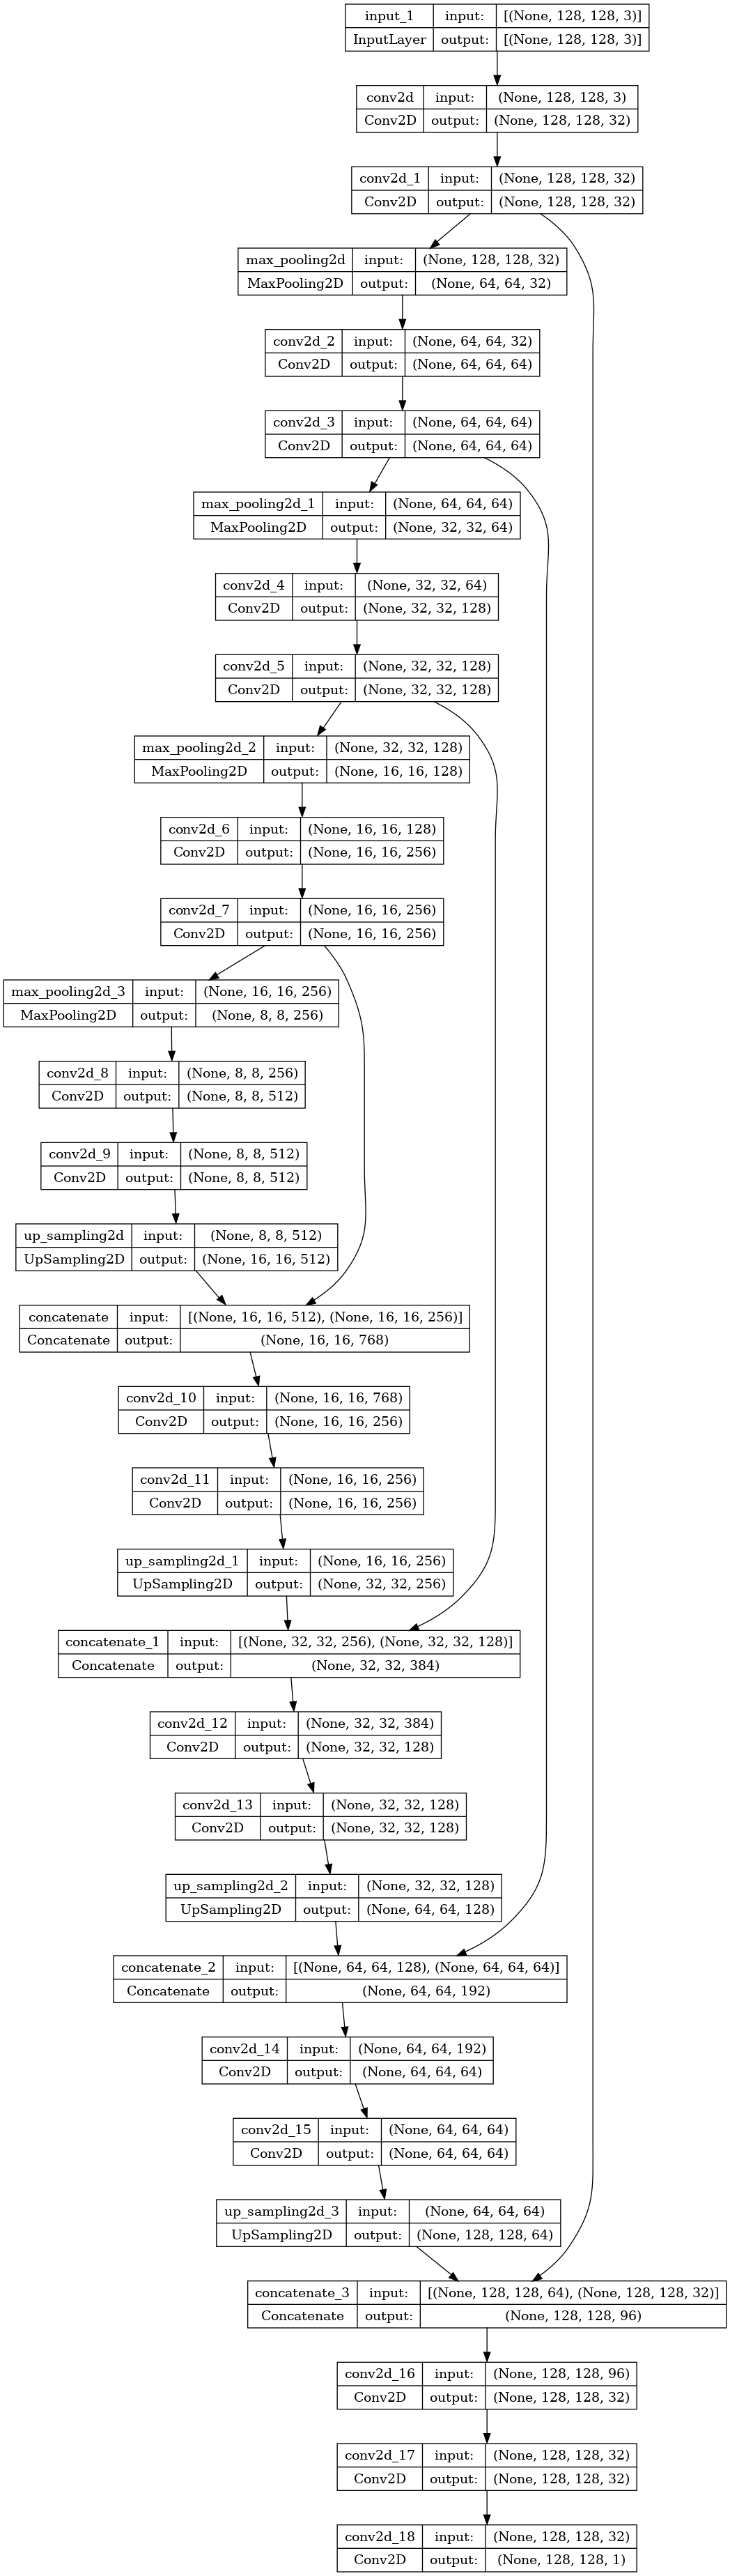

In [19]:
# Create the U-Net model
model = UNet((128, 128, 3), 32)

# Summarize the model
model.summary()

tf.keras.utils.plot_model(model, show_shapes=True)

# 7.10. Learning Rate Scheduler

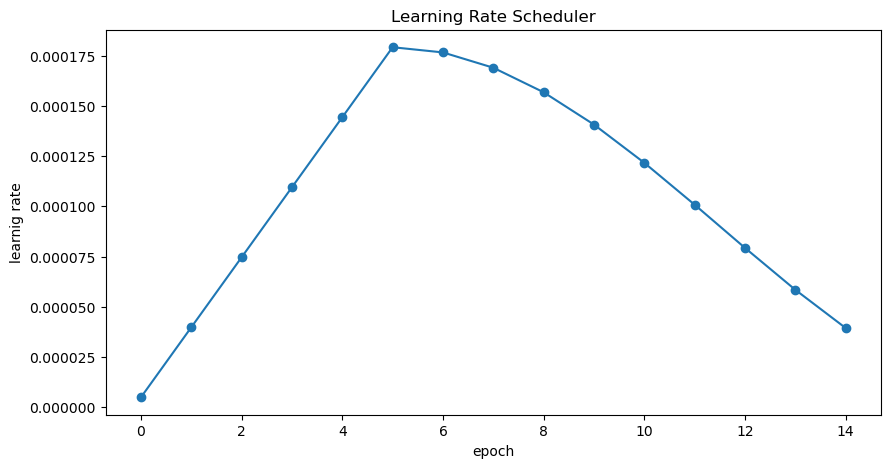

In [20]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=15, plot=False):
    """
    Create a learning rate scheduler callback.
    
    Parameters:
    - batch_size: the batch size during training
    - mode: the learning rate decrease mode ('exp', 'step', 'cos')
    - total_epochs: the total number of epochs during training
    - show_plot: a flag to show the learning rate schedule plot
    
    Returns:
    - a LearningRateScheduler callback
    """
    # Define the learning rate schedule.
    lr_start   = 0.000005
    lr_max     = 0.00000140 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    # Function to update the lr
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif mode == 'cos':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    
    # Plot the lr curve
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
        
    # Crate lr-callback to update lr during training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

lr_cb = get_lr_callback(batch_size=128, plot=True)

# 7.11. Training Model

In [21]:
# Print a message indicating the current fold, the model being used, the image size, and the batch size
print(f"{'#'*65}\nModel: UNet | ImgSize: {IMG_SIZE} | BatchSize: {BATCH_SIZE}")

# Select train and valid fold
train_df = train_df
valid_df = valid_df

# Step 1: Get the image paths and corresponding labels
train_paths = train_df['image_path'].tolist()
train_labels = train_df['mask_path'].tolist()

valid_paths = valid_df['image_path'].tolist()
valid_labels = valid_df['mask_path'].tolist()

print(f"Num Train: {len(train_paths)} | Num Valid: {len(valid_paths)}\n{'#'*65}")

# Step 2: Load the data
train_loader = DataLoader(train_paths, train_labels, dim=IMG_SIZE, 
                          batch_size=BATCH_SIZE, augment=True)
valid_loader = DataLoader(valid_paths, valid_labels, dim=IMG_SIZE,
                          batch_size=BATCH_SIZE, shuffle=False)

# Step 3: Build the model
model = UNet(input_shape=(*IMG_SIZE, 3), num_classes=1)

# Step 4: Build Callbacks
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(filepath = f'/kaggle/working/unet_best.h5',
                                             monitor = 'val_dice',
                                             verbose = 0,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'max')
lr_cb  = get_lr_callback(batch_size=128)

# Step 4: Train the model
print('>> Training')
history = model.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[ckpt_cb, lr_cb]) # to save best scoring model

# Step 5: Use the trained model to make predictions on the validation data
print("\n>> Inference")
valid_loader = DataLoader(valid_paths, valid_labels, batch_size=160, shuffle=False)
preds = model.predict(valid_loader)[:len(valid_df)]

#################################################################
Model: UNet | ImgSize: [128, 128] | BatchSize: 100
Num Train: 5594 | Num Valid: 1399
#################################################################
>> Training
Epoch 1/30
56/56 [==============================] - 239s 4s/step - loss: 0.6463 - dice: 0.4383 - val_loss: 0.6228 - val_dice: 0.5097 - lr: 5.0000e-06
Epoch 2/30
56/56 [==============================] - 116s 2s/step - loss: 0.2643 - dice: 0.7514 - val_loss: 0.1672 - val_dice: 0.8352 - lr: 3.9840e-05
Epoch 3/30
56/56 [==============================] - 116s 2s/step - loss: 0.1721 - dice: 0.8293 - val_loss: 0.1457 - val_dice: 0.8551 - lr: 7.4680e-05
Epoch 4/30
56/56 [==============================] - 115s 2s/step - loss: 0.1502 - dice: 0.8507 - val_loss: 0.1323 - val_dice: 0.8685 - lr: 1.0952e-04
Epoch 5/30
56/56 [==============================] - 137s 2s/step - loss: 0.1424 - dice: 0.8581 - val_loss: 0.1244 - val_dice: 0.8763 - lr: 1.4436e-04
Epoch 6/30
56/56 [===

## Plot History

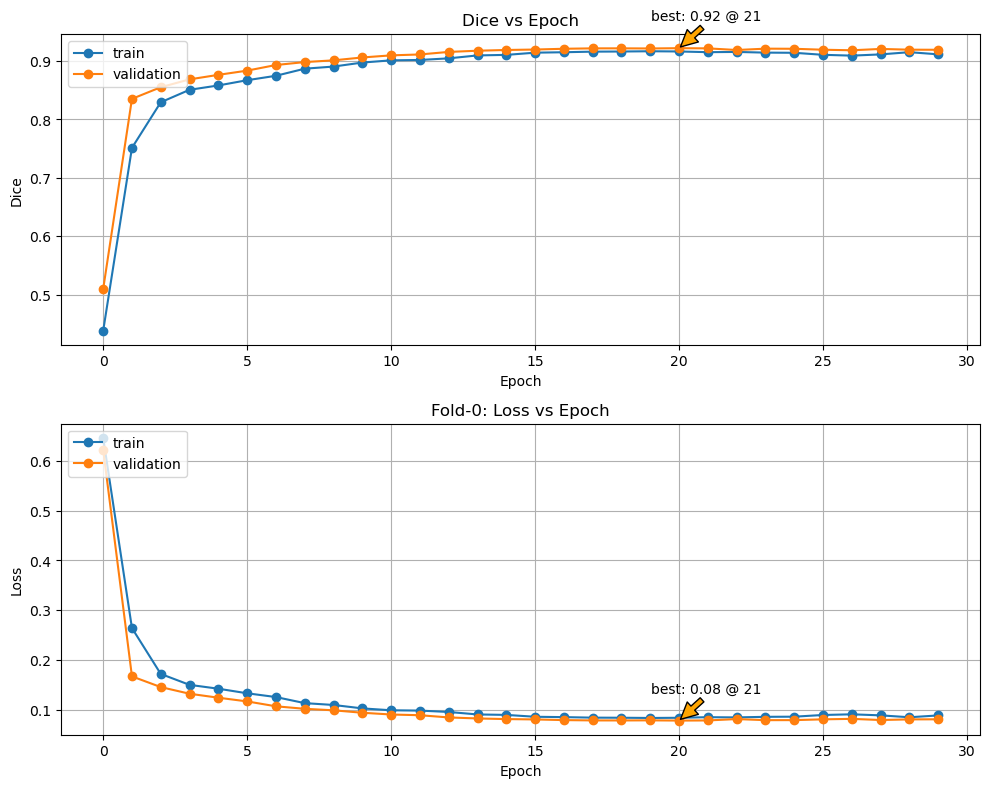

In [22]:
## Plot history of epochs
plot_history(history)

# 7.12. Result

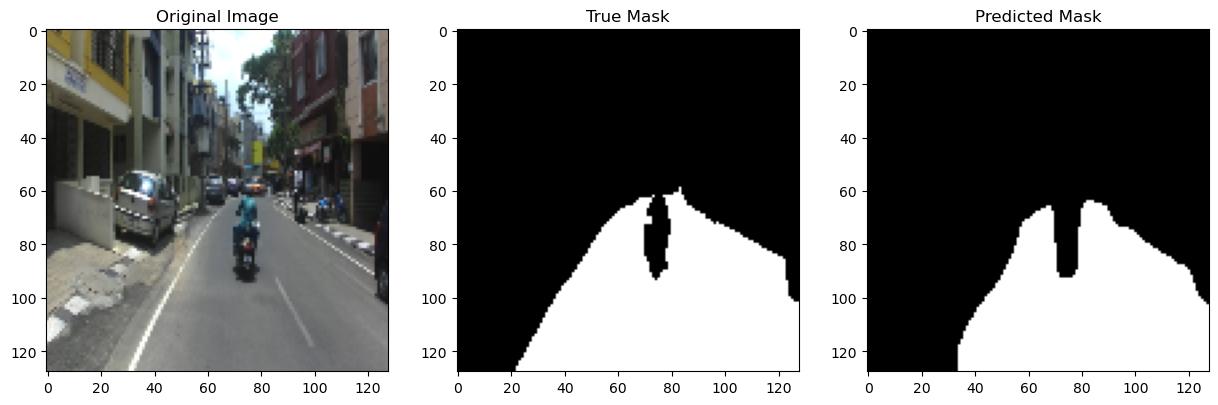

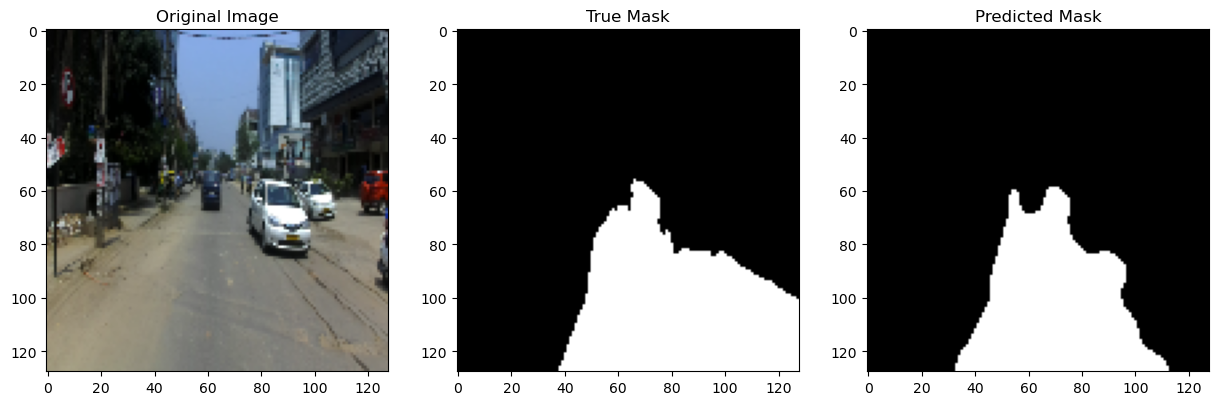

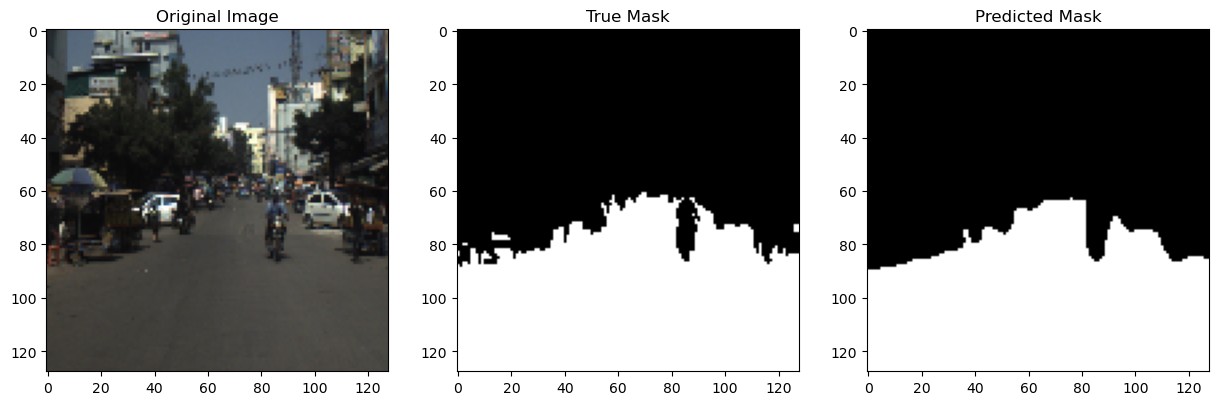

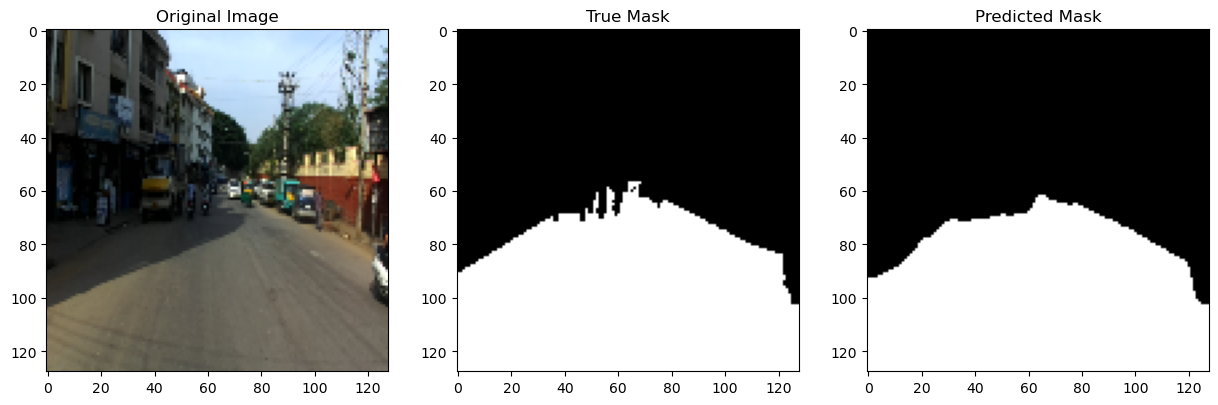

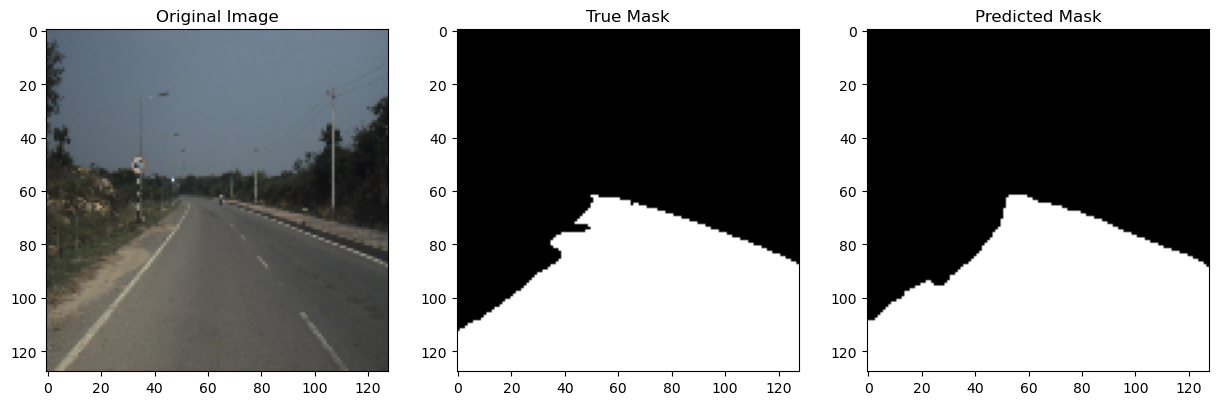

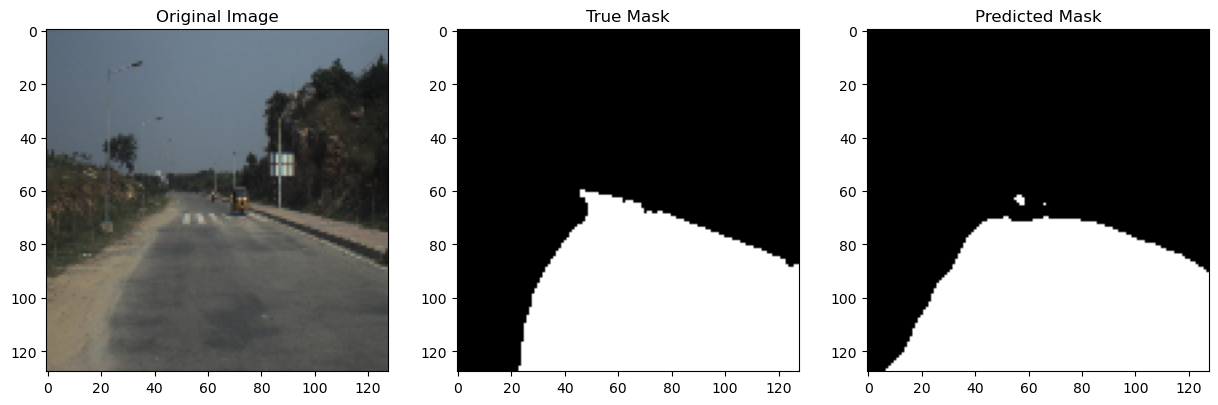

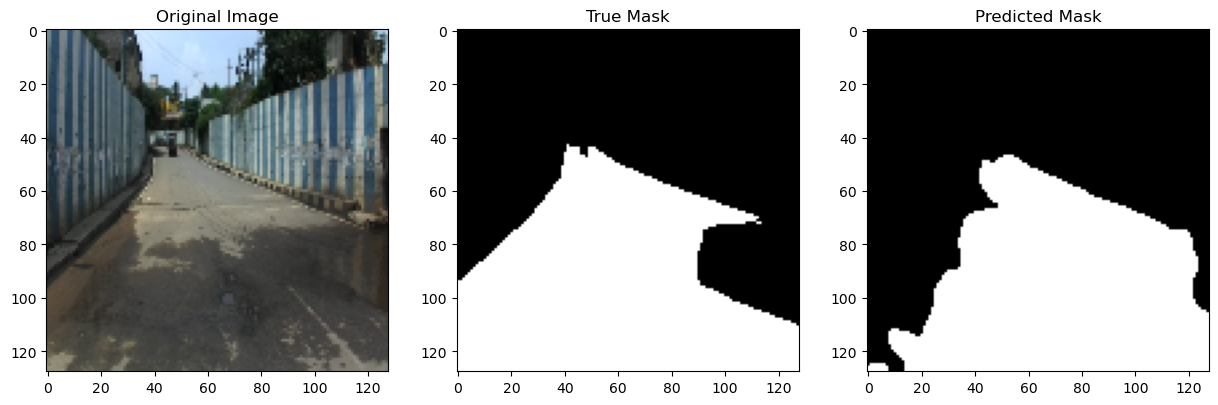

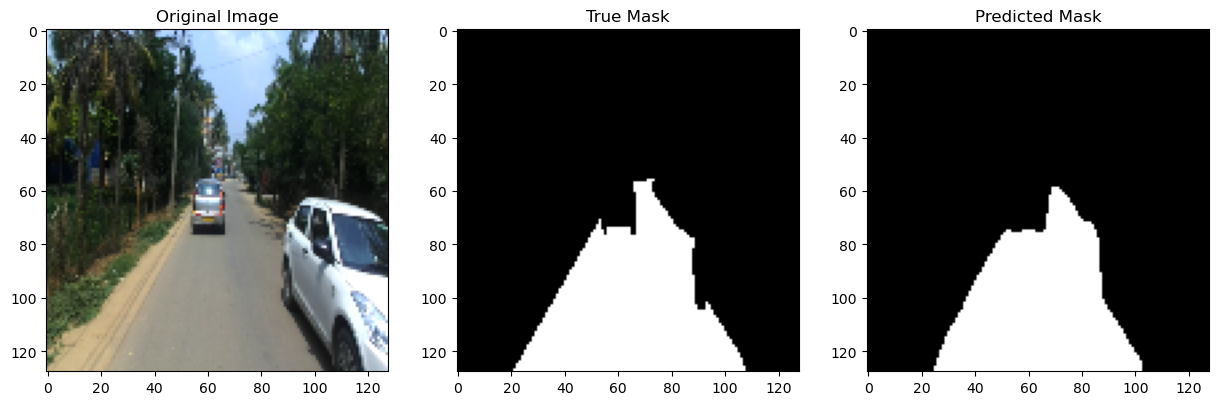

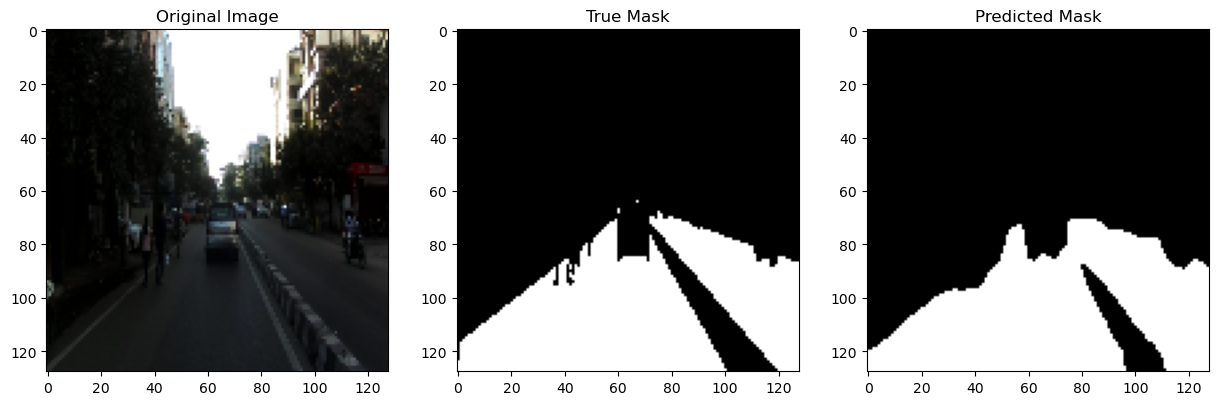

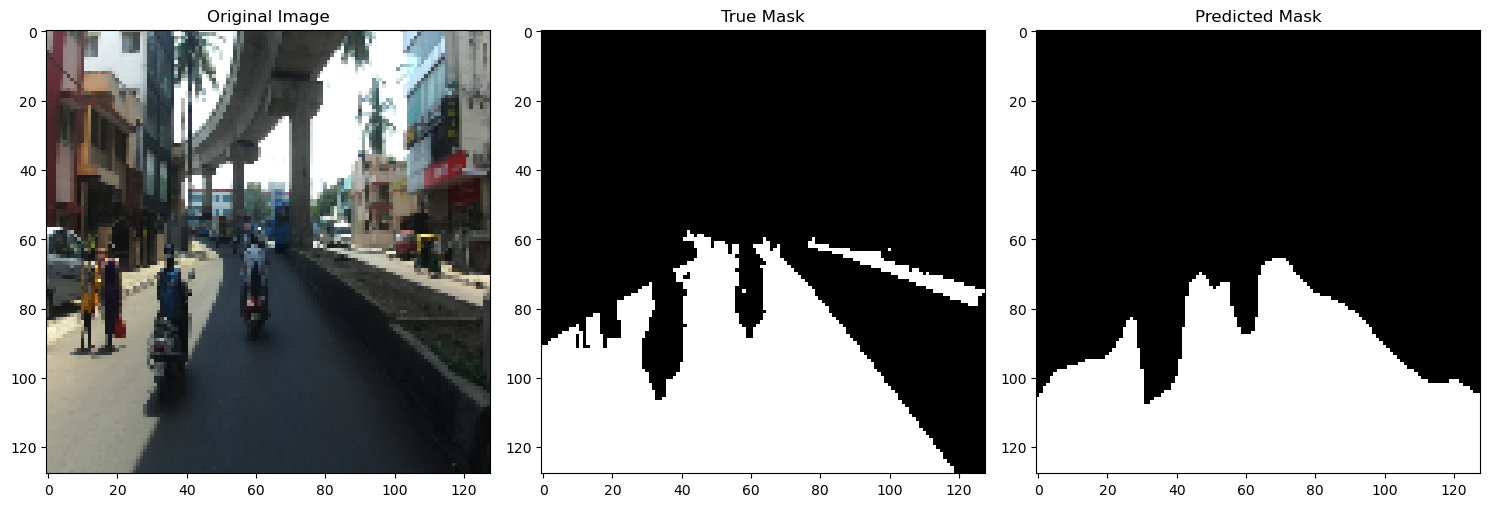

In [23]:
import random

def show_sample(image, mask, prediction=None):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask')
    
    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(prediction, cmap='gray')
        plt.title('Predicted Mask')

# Load Best Model
model = tf.keras.models.load_model(f'/kaggle/working/unet_best.h5', compile=False)


# Select a random sample of images and their corresponding masks from the validation dataset
num_samples = 10
idxs = random.sample(range(len(valid_paths)), num_samples)

for idx in idxs:
    # Load the image
    img = load_image(valid_paths[idx])
    img = cv2.resize(img, dsize=IMG_SIZE)

    # Load the corresponding mask
    true_mask = load_image(valid_labels[idx], 1)
    true_mask = cv2.resize(true_mask, dsize=IMG_SIZE)

    # Get the predicted mask
    pred_mask = preds[idx].reshape(IMG_SIZE)
    pred_mask = pred_mask > 0.5  # Apply a threshold to get binary output

    # Show the sample
    show_sample(img, true_mask, pred_mask)

plt.tight_layout()
plt.show()
